In [1]:
pip install yfinance pandas matplotlib scikit-learn tensorflow


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/51/31/72b8f5aa9ed9c4a6afd09c0bab491862ba5837facf7d81e1ed51a555ae8e/yfinance-0.2.44-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/86/20/2a2514d0b504e773078c38d664108bc8ae9056f85ea57c6fff86eee07331/frozendict-2.4.5-py311-none-any.whl.metadata
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     -- ------------------------------------- 0.2/3.0 MB 11.5 MB/s eta 0:00:01
     --- ------------------------------------ 0.3/3.0 MB 3.1 MB/s eta 0:00:01
     ------ --------------------------------- 0.5/3.0 MB 3.5 MB/s eta 0:00:01
     -------- ------------------------------- 0.7/3.0 MB 

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import logging

In [3]:
logging.basicConfig(level=logging.INFO)

# Step 1: Retrieve Dell Stock Data from Yahoo Finance
def get_stock_data(ticker='DELL', start='2010-01-01', end='2023-01-01'):
    """
    Function to fetch stock data from Yahoo Finance with error handling
    """
    try:
        logging.info("Fetching stock data for %s from %s to %s", ticker, start, end)
        stock_data = yf.download(ticker, start=start, end=end)
        if stock_data.empty:
            raise ValueError("No data found for the given ticker.")
        logging.info("Successfully retrieved stock data")
        return stock_data
    except Exception as e:
        logging.error("Error retrieving stock data: %s", e)
        raise

# Step 2: Data Preprocessing and Visualization
def preprocess_data(stock_data):
    """
    Preprocess stock data for time series modeling
    """
    try:
        stock_data = stock_data[['Close']]  # Focus only on 'Close' prices
        stock_data.fillna(method='ffill', inplace=True)  # Handle missing values
        if stock_data.isnull().values.any():
            raise ValueError("Missing values detected after preprocessing.")
        return stock_data
    except Exception as e:
        logging.error("Error in data preprocessing: %s", e)
        raise

def plot_stock_data(stock_data):
    """
    Plot the historical stock prices
    """
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data, label="Dell Stock Price")
    plt.title('Dell Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.show()

# Step 3: Prepare Data for LSTM Model
def prepare_lstm_data(stock_data, time_step=60):
    """
    Prepare data for LSTM modeling by creating sequences
    """
    try:
        scaler = MinMaxScaler(feature_range=(0, 1))  # Scaling the data
        stock_scaled = scaler.fit_transform(stock_data)

        # Creating training sequences
        X, y = [], []
        for i in range(time_step, len(stock_scaled)):
            X.append(stock_scaled[i-time_step:i, 0])
            y.append(stock_scaled[i, 0])
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape to LSTM input shape

        return X, y, scaler
    except Exception as e:
        logging.error("Error preparing data for LSTM: %s", e)
        raise

# Step 4: Build the LSTM Model
def build_lstm_model(input_shape):
    """
    Build the LSTM model architecture
    """
    try:
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dense(units=25))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        logging.info("LSTM model built successfully")
        return model
    except Exception as e:
        logging.error("Error building LSTM model: %s", e)
        raise

# Step 5: Train the Model and Make Predictions
def train_model(model, X_train, y_train, epochs=10, batch_size=64):
    """
    Train the LSTM model on stock data with error handling
    """
    try:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
        logging.info("Model training completed successfully")
    except Exception as e:
        logging.error("Error during model training: %s", e)
        raise

def forecast_stock_price(model, stock_data, scaler, time_step=60):
    """
    Forecast future stock prices using the LSTM model
    """
    try:
        last_values = stock_data[-time_step:].values
        last_values_scaled = scaler.transform(last_values)
        
        X_input = last_values_scaled.reshape(1, time_step, 1)
        predicted_price_scaled = model.predict(X_input)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        
        return predicted_price[0][0]
    except Exception as e:
        logging.error("Error forecasting stock price: %s", e)
        raise

INFO:root:Fetching stock data for DELL from 2010-01-01 to 2023-01-01
[*********************100%***********************]  1 of 1 completed
INFO:root:Successfully retrieved stock data
C:\Users\aviii\AppData\Local\Temp\ipykernel_21232\1991909172.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.fillna(method='ffill', inplace=True)  # Handle missing values


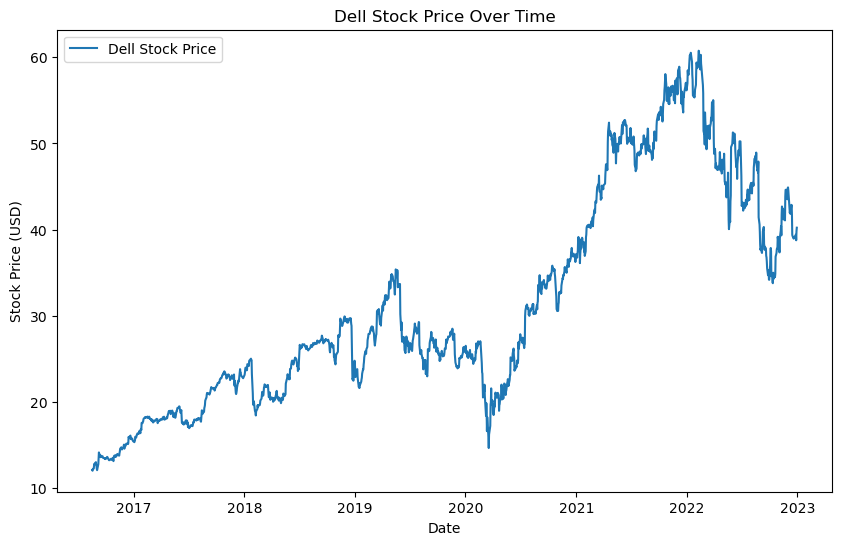

C:\Users\aviii\anaconda33\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:root:LSTM model built successfully


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0433
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0026
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 8.8788e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 7.8653e-04
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 8.5638e-04
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 6.9662e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 6.5512e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 7.2849e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 8.2679e-04
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 6.6799e-04
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 7.5731e-04
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 6.4442e-04
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 6.6840e-04
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 6.3066e-04
Epoch 15/20
20/

INFO:root:Model training completed successfully


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


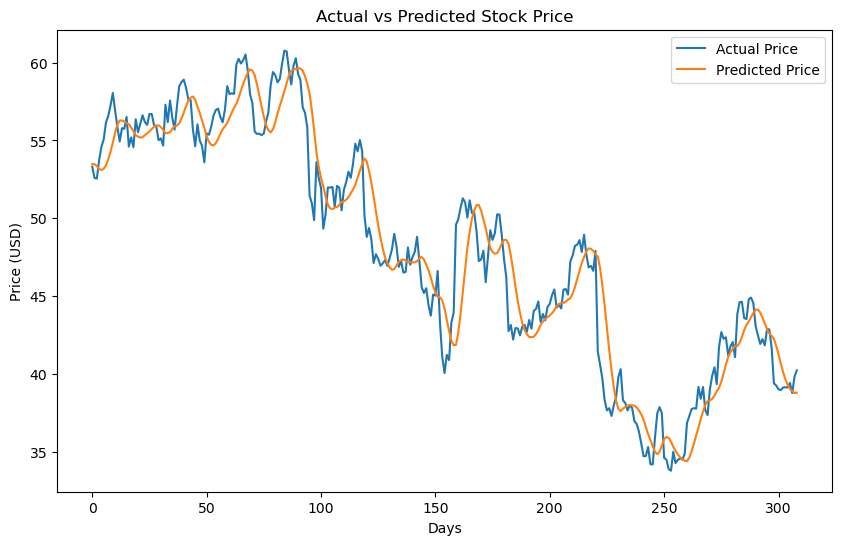

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Future Price: 38.9262580871582 USD


C:\Users\aviii\anaconda33\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [4]:
# Main Code Execution
if __name__ == '__main__':
    try:
        # Retrieve stock data
        stock_data = get_stock_data()

        # Preprocess and visualize the data
        stock_data = preprocess_data(stock_data)
        plot_stock_data(stock_data)

        # Prepare the data for LSTM
        time_step = 60
        X, y, scaler = prepare_lstm_data(stock_data, time_step=time_step)

        # Split the data into training and testing sets
        split_ratio = 0.8
        train_size = int(len(X) * split_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Build the LSTM model
        model = build_lstm_model((X_train.shape[1], 1))

        # Train the model
        train_model(model, X_train, y_train, epochs=20, batch_size=64)

        # Evaluate the model using test data
        predicted_prices = model.predict(X_test)
        predicted_prices = scaler.inverse_transform(predicted_prices)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Plot actual vs predicted prices
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_actual, label="Actual Price")
        plt.plot(predicted_prices, label="Predicted Price")
        plt.title("Actual vs Predicted Stock Price")
        plt.xlabel("Days")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.show()

        # Forecast future price
        future_price = forecast_stock_price(model, stock_data, scaler, time_step)
        print(f"Predicted Future Price: {future_price} USD")
    except Exception as e:
        logging.error("An error occurred: %s", e)

[*********************100%***********************]  1 of 1 completed
C:\Users\aviii\anaconda33\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aviii\anaconda33\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aviii\anaconda33\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aviii\anaconda33\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with a

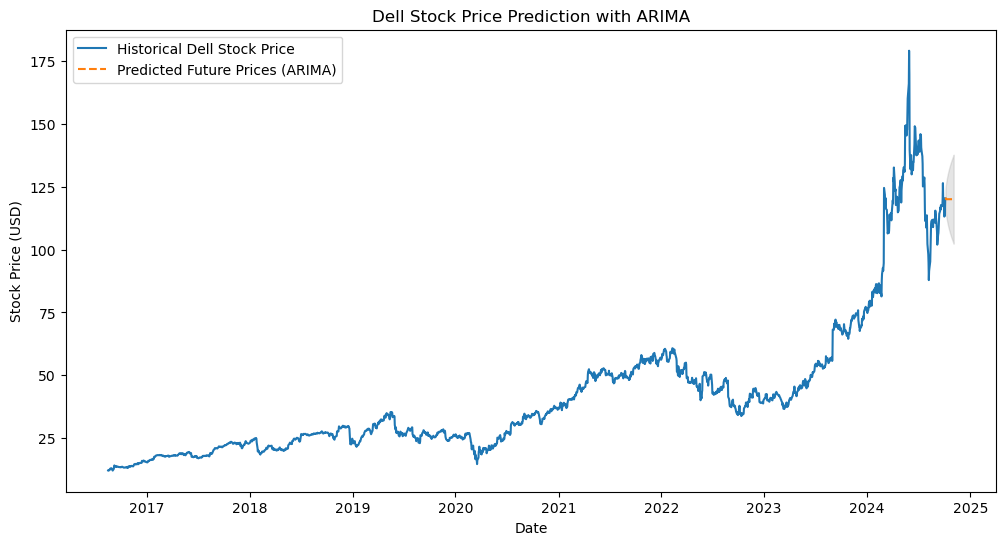

In [6]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import datetime

# Step 1: Retrieve Dell Stock Data from Yahoo Finance
def get_stock_data(ticker='DELL', start='2010-01-01', end=None):
    """
    Fetch stock data from Yahoo Finance.
    :param ticker: Stock ticker symbol
    :param start: Start date for data retrieval
    :param end: End date for data retrieval (default is today)
    :return: Pandas DataFrame of stock data
    """
    if end is None:
        end = datetime.datetime.today().strftime('%Y-%m-%d')
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Step 2: Train ARIMA model
def train_arima(stock_data, order=(5,1,0)):
    """
    Train an ARIMA model on stock data.
    :param stock_data: Historical stock prices
    :param order: ARIMA order parameters (p, d, q)
    :return: Trained ARIMA model
    """
    model = ARIMA(stock_data['Close'], order=order)
    arima_result = model.fit()
    return arima_result

# Step 3: Predict Future Stock Prices using ARIMA
def predict_future_prices_arima(model, steps=30):
    """
    Predict future stock prices using a trained ARIMA model.
    :param model: Trained ARIMA model
    :param steps: Number of days to predict into the future
    :return: Predicted prices (future) and confidence intervals
    """
    forecast = model.get_forecast(steps=steps)
    predicted_prices = forecast.predicted_mean
    conf_int = forecast.conf_int()
    return predicted_prices, conf_int

# Step 4: Plot the Historical and Future Stock Prices
def plot_predictions_arima(stock_data, predicted_prices, conf_int, future_days=30):
    """
    Plot historical and future predicted stock prices (ARIMA).
    :param stock_data: Historical stock prices
    :param predicted_prices: Predicted future stock prices
    :param conf_int: Confidence intervals of the predictions
    :param future_days: Number of future days to predict
    """
    last_date = stock_data.index[-1]
    future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data['Close'], label='Historical Dell Stock Price')
    plt.plot(future_dates, predicted_prices, label='Predicted Future Prices (ARIMA)', linestyle='--')
    
    # Plot confidence intervals
    plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2)
    
    plt.title('Dell Stock Price Prediction with ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.show()

# Main Code Execution
if __name__ == '__main__':
    # Step 1: Retrieve Dell stock data
    stock_data = get_stock_data(ticker='DELL', start='2010-01-01')

    # Step 2: Train ARIMA model (5,1,0) is a common choice for stock data
    arima_model = train_arima(stock_data, order=(5, 1, 0))

    # Step 3: Predict future stock prices for the next 30 days
    future_days = 30
    predicted_prices, conf_int = predict_future_prices_arima(arima_model, steps=future_days)

    # Step 4: Plot historical and predicted prices with confidence intervals
    plot_predictions_arima(stock_data, predicted_prices, conf_int, future_days=future_days)
